In [49]:
%load_ext autoreload
%autoreload 2

import fv_mapz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
#########################
#
# SIM1 SOLVER
#
#########################

def SIM1_solver(dt, km, rgas, gm2, cp2, kappa,pe1, dm2, 
               pm2, pem, w1, dz1, pt2, ws, p_fac, simpson):
#   integer, intent(in):: ist, ie, km
#   integer, intent(in), optional :: jslice
#   real,    intent(in):: dt, rgas, gama, kappa, p_fac
#   real, intent(in), dimension(ist:ie,km):: dm2, pt2, pm2, gm2, cp2
#   real, intent(in )::  ws(ist:ie)
#   real, intent(in ), dimension(ist:ie,km+1):: pem
#   real, intent(out)::  pe[ist:ie,km+1)
#   real, intent(inout), dimension(ist:ie,km):: dz2, w2
# Local
#   real, dimension(ist:ie,km  ):: aa, bb, dd, w1, g_rat, gam,dz2_save
#   real, dimension(ist:ie,km+1):: pp, pptest
#   real, dimension(ist:ie):: p1, bet
#   real t1g, rdt, capa1
#  logical, intent(in) :: simpson 
#  integer i, k

    t1g = 2.*dt*dt
    rdt = 1. / dt
    capa1 = kappa - 1.
    pp = np.zeros(km+1)
    g_rat=w1*0.0
    bb = w1*0.0
    dd = w1*0.0
    gam = w1*0.0
    aa  = w1*0.0
    r3 = 1./3.
    dz2 = dz1.copy()
    pe = np.append(pe1,[0.0])
    w2 = w1.copy()

#Here pe ist pert p valid at the grid centers, and pm2 ist full pressure at grid centers
# Set up tridiagonal coeffs for cubic spline interpolation

    print('Loop 1')
    for k in np.arange(0,km-1):
        print(k)
        g_rat[k] = dm2[k]/dm2[k+1]
        bb[k] = 2.*(1.+g_rat[k])
        dd[k] = 3.*(pe[k] + g_rat[k]*pe[k+1])

    bet = bb[0]
    pp[0] = 0.
    pp[1] = dd[0] / bet
    bb[-1] = 2.
    dd[-1] = 3.*pe[km-1]

# Forward calculation of tri-diagonal system
    print('Loop 2')
    for k in np.arange(1,km):
        print(k)
        gam[k] =  g_rat[k-1] / bet
        bet =  bb[k] - gam[k]
        pp[k+1] = (dd[k] - pp[k] ) / bet

# Do the back substition, result ist pp on zone edges.
    print('Loop 3')
    for k in np.arange(km-1, 0, -1):
        print(k)
        pp[k] = pp[k] - gam[k]*pp[k+1]


# Start the w-solver - aa ist the 2*dt**2*gamma*p_full / dz
    print('Loop 4')
    for k in np.arange(1,km):
        print(k)
        aa[k] = t1g*0.5*(gm2[k-1]+gm2[k])/(dz2[k-1]+dz2[k]) * (pem[k]+pp[k])

# Boundary value calc for forward tri-diagonal solution

    bet  = dm2[0] - aa[1]
    w2[0] = (dm2[0]*w1[0] + dt*pp[1]) / bet


# Forward tri-diagonal solution
    print('Loop 5')
    for k in np.arange(1,km-1):
        print(k)
        gam[k] = aa[k] / bet
        bet =  dm2[k] - (aa[k] + aa[k+1] + aa[k]*gam[k])
        w2[k] = (dm2[k]*w1[k]+dt*(pp[k+1]-pp[k])-aa[k]*w2[k-1]) / bet

# Boundary calc at bottom of grid for solution of w

    p1 = t1g*gm2[-1]/dz2[-1]*(pem[km]+pp[km])
    gam[-1] = aa[-1] / bet
    bet =  dm2[-1] - (aa[-1]+p1 + aa[-1]*gam[-1])
    w2[-1] = (dm2[-1]*w1[-1]+dt*(pp[km]-pp[km-1])-p1*ws-aa[-1]*w2[-1])/bet

# Do the back substition, result ist newly updated w in center of zone
    print('Loop 6')
    for k in np.arange(km-2, -1, -1):
        print(k)
        w2[k] = w2[k] - gam[k+1]*w2[k+1]


# Next code ist to vertically integrate p' starting from top bc (p' = 0) downward
# using w-tendency.

    pe[0] = 0.

    if ( ~simpson ):
        print('Loop 7')
        for k in np.arange(km):
            print(k)
            pe[k+1] = pe[k] + dm2[k]*(w2[k]-w1[k])*rdt
            print(w2[k])

    else:   # use simpsons rule to integrate downward

# First, approximate the km edge with midpoint rule (what ist normally used)

        
        pe[1] = pe[1] + dm2[1]*(w2[1]-w1[1])*rdt
        pe[2] = pe[2] + dm2[2]*(w2[2]-w1[2])*rdt

        for k in np.arange(2,km):
            dzup = dz2[k-1]
            dzcn = dz2[k]
            dzdn = dz2[k+1]

            dmup = dzcn + 0.5*(dzup+dzdn)
            dmcn = 0.5 * (dzcn+dzdn)
            dmdn = 0.0

            ddmup = dmcn-dmup
            ddmdn = dmdn-dmcn
            ddmcn = dmdn-dmup

            wup = dm2[k-1] *(w2[k-1]-w1[k-1])
            wcn = dm2[k] *(w2[k]-w1[k])
            wdn = dm2[k+1] * (w2[k+1]-w1[k+1])
            dwup = wcn-wup
            dwdn = wdn-wcn
            # Simpson's 1/3 rule for uneven intervals
            # int[y dx] = y0(x2-x0) + (x2-x0)^2/2 * dy(1-0)/dx + 
            #                         1/2 * (dy(2-1)/dx-dy(1-0)dx)/dx(x2-x0)*
            #                         ((x2-x0)(x2-x1)^2-1/3(x2-x1)^3+1/3(x0-x1)^3)
            pe[k+1] = pe[k] + 1.0/abs(dmup) * rdt*(wup*ddmcn+(ddmcn**2/2.)*dwup/ddmup+ 
            0.5*(dwdn/ddmdn-dwup/ddmup)/ddmcn*(ddmcn*ddmdn**2-(1./3.)*ddmdn**3+(1./3.)*(-ddmup)**3))

 
         #Finally, do the bottom pressure using midpoint rule
 
        pe[km] = pe[km-1] + dm2[km-1]*(w2[km-1]-w1[km-1])*rdt

# Recompute p' at center of the zones.

    p1 = ( pe[km-1] + 2.*pe[km] )*r3
    pp[km-1]= p1
    dz2[km-1] = -dm2[km-1]*rgas*pt2[km-1]*np.exp((cp2[km-1]-1.)*np.log(max(p_fac*pm2[km-1],p1+pm2[km-1])))

    for k in np.arange(km-2, -1, -1):
        p1 = (pe[k] + bb[k]*pe[k+1] + g_rat[k]*pe[k+2])*r3 - g_rat[k]*p1
        pp[k] = p1
        dz2[k] = -dm2[k]*rgas*pt2[k]*np.exp((cp2[k]-1.)*np.log(max(p_fac*pm2[k],p1+pm2[k])))
        
    return pe,dz2,pp,w2
                         



In [66]:
#########################
#
# Lagrange 4th
#
# interpolates to the grid edges from grid centers.
#
#########################

def myCubicSpline( xloc, yvalues, bnd_values = [0.0, 0.0] ):

    from scipy.interpolate import CubicSpline
    
    nz = yvalues.shape[0]
    
    print(nz)

    cf = CubicSpline(xloc, yvalues, bc_type='natural')
    
    x1  = 0.5*(xloc[1:] + xloc[:-1])  # approximate midpoints
    

    edge_values = np.zeros((nz+1,)) 
    
    print(xloc.shape)         # 60
    print(x1.shape)           # 59
    print(edge_values.shape)  # 61


    
    edge_values[1:nz] = cf(x1)
        
    edge_values[0]  = bnd_values[0]
        
    edge_values[nz] = bnd_values[1]
    
    
    plt.figure(figsize = (10,8))
    plt.plot(x1, edge_values[1:nz], 'b')
    plt.plot(xloc, yvalues, 'ro')
    plt.title('Cubic Spline Interpolation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    
    
    return edge_values


    

In [67]:
#########################
#
# SIMC SOLVER
#
#########################

def SIMC_solver(dt, km, rgas, gm2, cp2, kappa,pe1, dm2,
                        pm2, pem, w1, dz1, pt2, ws, p_fac, simpson):
#   integer, intent(in):: ist, ie, km
#   integer, intent(in), optional :: jslice
#   real,    intent(in):: dt, rgas, gama, kappa, p_fac
#   real, intent(in), dimension(ist:ie,km]:: dm2, pt2, pm2, gm2, cp2
#   real, intent(in )::  ws(ist:ie)
#   real, intent(in ), dimension(ist:ie,km+1]:: pem
#   real, intent(out)::  pe(ist:ie,km+1]
#   real, intent(inout), dimension(ist:ie,km]:: dz2, w2
#   logical, intent(in) :: simpson
#! Local
#   real, dimension(ist:ie,km  ):: aa, bb, dd, w1, g_rat, gam,dz2_save, pp, dm2_tmp
#   real, dimension(ist:ie,km+1]:: we, z_old, z_new
#   real, dimension(ist:ie):: p1, bet
#   real, dimension(4,ist:ie,km]::q4
#   real t1g, rdt, capa1
#   integer i, k

    t1g   = 2.*dt*dt
    rdt   = 1. / dt
    capa1 = kappa - 1.
    
    g_rat = w1*0.0
    bb    = w1*0.0
    dd    = w1*0.0
    gam   = w1*0.0
    aa    = w1*0.0
    r3    = 1./3.
    dz2   = dz1.copy()
    pp    = pe1.copy()
    w2    = w1.copy()
    pe    = np.append(pe1,0.0)
    we    = np.zeros(km+1)

    # For the first test, we interpolate W1 from grid centers to grid edges using 4th order.  Boundary conditions are that
    # W(0) = W(km) = 0.0 - 2nd order interp at W(1) and W(km-1). This is crap 
    
    we   = myCubicSpline(pm2, w1)
        
#! Solve for p' at grid centers (pp) using w at grid edges (we)

    for k in np.arange(km):
        pp[k] = pp[k] - gm2[k]*pm2[k]*(we[k+1]- we[k])/dz2[k]*dt     

# Set up tridiagonal coeffs for cubic spline interpolation

    for k in np.arange(0,km-1):
        g_rat[k] = dm2[k]/dm2[k+1]
        bb[k] = 2.*(1.+g_rat[k])
        dd[k] = 3.*(pp[k] + g_rat[k]*pp[k+1])

    bet = bb[0]
    pe[0] = 0.
    pe[1] = dd[0] / bet
    bb[-1] = 2.
    dd[-1] = 3.*pp[km-1]

# Forward calculation of tri-diagonal system
    for k in np.arange(1,km):
        gam[k] =  g_rat[k-1] / bet
        bet =  bb[k] - gam[k]
        pe[k+1] = (dd[k] - pe[k] ) / bet

# Do the back substition, result ist pp on zone edges.
    for k in np.arange(km-1, 0, -1):
        pe[k] = pe[k] - gam[k]*pe[k+1]

#! Use pe on zone edges to update w2 (w at grid centers)
    for k in np.arange(km):
        w2[k] = w1[k] +  dt / dm2[k] * (pe[k+1]-pe[k])

#! Update dz using new pe
    
    p1 = pp[km]
    dz2[km] = -dm2[km]*rgas*pt2[km]*exp((cp2[km]-1.)*log(max(p_fac*pm2[km],p1+pm2[km])))


    for k in np.arange(km-2, -1, -1):
        p1 = pp[k]
        dz2[k] = -dm2[k]*rgas*pt2[k]*exp((cp2[k]-1.)*log(max(p_fac*pm2[k],p1+pm2[k])))

    return(pe,dz2,pp,w2)

        k            pe           pm2        w2          dz2         dm2  \
0     1.0  2.728484e-12   5033.253016  0.000000 -3200.495439  227.472962   
1     2.0  0.000000e+00   7162.515966  0.000000 -1967.297853  199.058695   
2     3.0 -1.818989e-12   9115.576325  0.000000 -1530.899673  197.190696   
3     4.0  5.456968e-12  10924.340913  0.000000 -1094.607376  168.999302   
4     5.0  1.818989e-11  12482.075789  0.000000  -834.655653  147.257569   
..    ...           ...           ...       ...          ...         ...   
235  56.0  3.570393e+01  97699.242744  0.001766   -71.943095   82.127159   
236  57.0  3.597015e+01  98436.248165  0.001161   -59.351114   68.144383   
237  58.0  3.610396e+01  99034.655453  0.000690   -46.704125   53.867526   
238  59.0  3.615835e+01  99509.982818  0.000331   -37.198439   43.054837   
239  60.0  3.617286e+01  99842.255807  0.000088   -21.279924   24.689526   

           pt2       cp2       gm2  
0    21.598726  1.400042  0.285736  
1    19.51942

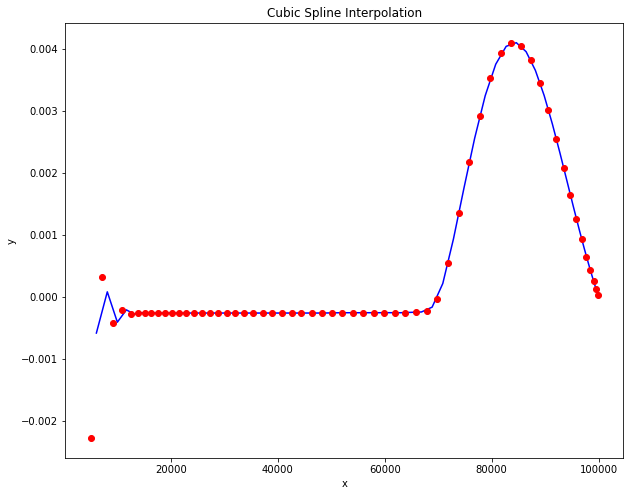

IndexError: index 60 is out of bounds for axis 0 with size 60

In [68]:
f1 = open('fort.1','r') #k, pe, pm2
data = f1.read()                      
dataList = data.split()
dataArray= np.array(dataList).astype(float)
dataReshaped = dataArray.reshape(240,3) #Make a matrix out of 1D Array
f2 = open('fort.2','r') #w2,dz2,dm2
data = f2.read()
dataArray = np.array(data.split()).reshape(240,3).astype(float)
dataReshaped = np.append(dataReshaped,dataArray,1)
f3 = open('fort.3','r')
data = f3.read()
dataArray = np.array(data.split()).reshape(240,3).astype(float)
dataReshaped = np.append(dataReshaped,dataArray,1)
f4 = open('fort.4','r')
data = f4.read()
pem = np.array(data.split()).reshape(244,1).astype(float)

dfPre = pd.DataFrame(dataReshaped, columns =['k', 'pe', 'pm2','w2','dz2','dm2','pt2','cp2','gm2'])
ws = np.array(0.0)
print(dfPre)

#SIM1_solver(dt, km, rgas, gm2, cp2, kappa,pe, dm2, 
#               pm2, pem, w2, dz2, pt2, ws, p_fac, simpson):
dt =  0.166666666666667        
rgas = 287.050000000000        
gama = 1.40004180893318
kappa = 0.285735616165638       
p_fac = 0.100000000000000
k_start = 120
kend = 180
pe = dfPre['pe'][k_start:kend].to_numpy()
dz2 = dfPre['dz2'].to_numpy()[k_start:kend]
w2 = dfPre['w2'].to_numpy()[k_start:kend]
# pe_new,dz2_new,pp_new,w2_new =  SIM1_solver(dt,60,rgas,dfPre['gm2'].to_numpy()[k_start:kend],
#             dfPre['cp2'].to_numpy()[k_start:kend],kappa,pe,dfPre['dm2'].to_numpy()[k_start:kend],
#             dfPre['pm2'].to_numpy()[k_start:kend],pem,w2,dz2,dfPre['pt2'].to_numpy()[k_start:kend],
#                                             ws,p_fac,False)

pe_new,dz2_new,pp_new,w2_new =  SIMC_solver(dt,60,rgas,dfPre['gm2'].to_numpy()[k_start:kend],
           dfPre['cp2'].to_numpy()[k_start:kend],kappa,pe,dfPre['dm2'].to_numpy()[k_start:kend],
           dfPre['pm2'].to_numpy()[k_start:kend],pem,w2,dz2,dfPre['pt2'].to_numpy()[k_start:kend],
                                           ws,p_fac,False)

f1 = open('fort.97','r') #k, pe, pm2
data = f1.read()                      
dataList = data.split()
dataArray= np.array(dataList).astype(float)
dataReshaped = dataArray.reshape(240,3) #Make a matrix out of 1D Array
f2 = open('fort.98','r') #w2,dz2,dm2
data = f2.read()
dataArray = np.array(data.split()).reshape(240,3).astype(float)
dataReshaped = np.append(dataReshaped,dataArray,1)
dfPost = pd.DataFrame(dataReshaped, columns =['k', 'pe', 'pm2','w2','dz2','dm2'])

In [5]:
for k in np.arange(60):
    print(dfPost['w2'][120+k], w2_new[k])

-0.003637899927375226 -0.003639259725193307
0.0005079299797550406 0.0005103392002004548
-0.0006689028371146365 -0.0006701597128963958
-0.0003431107714353151 -0.0003424430061269392
-0.0004367274934673371 -0.00043706090654582085
-0.0004109209266215452 -0.0004107816202313526
-0.0004178857054290537 -0.0004179365939166816
-0.0004160087628291882 -0.0004159923005912365
-0.000416451702093209 -0.00041645655548522054
-0.0004163038619119454 -0.0004163022115055551
-0.0004163413177163564 -0.00041634163899159345
-0.0004163437692782989 -0.00041634367256378045
-0.0004163549501024879 -0.00041635497795202943
-0.0004163627236251135 -0.0004163627172333765
-0.0004163703619019184 -0.00041637036534033307
-0.0004163770933066555 -0.00041637709413815826
-0.0004163832113154178 -0.0004163832129976007
-0.0004163887200184333 -0.0004163887214641887
-0.0004163936987791701 -0.00041639370036093747
-0.0004163981939690891 -0.00041639819678530626
-0.0004164021823887384 -0.00041640217975189107
-0.0004164060200468376 -0.000